# 1d Poisson, 1 output
---
$$
\begin{aligned}
&\frac{d^2 y}{dx^2} = 2, \ x\in [-1, 1], \\
&x(-1) = 0, x(1) = 2.
\end{aligned}
$$

Solution:
$$
y = x^2+x.
$$

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
model = keras.models.Sequential([
	keras.layers.Dense(128, input_shape = (1,), activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(128, activation = "tanh", kernel_initializer = "random_normal"),
	keras.layers.Dense(1, use_bias = True)
])

loss_func = keras.losses.MeanSquaredError()

In [3]:
def get_residue_loss(tape, x, y):
    dy_dx = tape.gradient(y, x)
    dy_dxx = tape.gradient(dy_dx, x)
    return loss_func(dy_dxx, 2.0)

def step(dataset):
	with tf.GradientTape(persistent = True) as tape:
		tape.watch(dataset)
		[x_b, y_b, x_c] = dataset
		
		y_b_pred = model(x_b)
		y_c = model(x_c)
		
		loss_c = get_residue_loss(tape, x_c, y_c)
		loss_br = get_residue_loss(tape, x_b, y_b_pred)
		loss_bv = loss_func(y_b_pred, y_b)
		loss = w_c*loss_c + w_br*loss_br + w_bv*loss_bv
	grads = tape.gradient(loss, model.trainable_variables)
	optimizer.apply_gradients(zip(grads, model.trainable_variables))
	del tape
	return loss, loss_c, loss_br, loss_bv

def train(iterations, start_iteration, dataset,print_every = 100, save_every = 10000, save_path = None):
	iteration = start_iteration
	
	while iteration < start_iteration + iterations:
		iteration += 1
		loss = step(dataset)

		if iteration % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, c: {:.4e}, br: {:.4e}, bv: {:.4e}".format(get_time(), iteration, *list(loss)))

In [4]:
np.random.seed(1)
x_c = transform(np.random.random((1000, 1)), -1, 1)

f = lambda x: x**2 + x
x_b = np.array([-1, 1]).reshape((-1, 1))
y_b = f(x_b)

dataset = cast_to_tf_constant([x_b, y_b, x_c])

In [5]:
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c = w_br = w_bv = 1.0
iterations = 10000
import time
start_time = time.time()
train(iterations, 0, dataset, 100)
end_time = time.time()
print("Avg duration per epoch:", (end_time-start_time)/iterations)

2020/07/19, 03:22:22, Epoch: 100, Loss: 8.1718e+00, c: 4.0622e+00, br: 4.0592e+00, bv: 5.0392e-02
2020/07/19, 03:22:26, Epoch: 200, Loss: 8.1059e+00, c: 4.0487e+00, br: 4.0470e+00, bv: 1.0156e-02
2020/07/19, 03:22:30, Epoch: 300, Loss: 8.0824e+00, c: 4.0382e+00, br: 4.0371e+00, bv: 7.1555e-03
2020/07/19, 03:22:34, Epoch: 400, Loss: 8.0560e+00, c: 4.0256e+00, br: 4.0252e+00, bv: 5.1607e-03
2020/07/19, 03:22:39, Epoch: 500, Loss: 7.9150e+00, c: 3.9527e+00, br: 3.9593e+00, bv: 3.0500e-03
2020/07/19, 03:22:43, Epoch: 600, Loss: 1.9774e+00, c: 5.3331e-01, br: 1.4358e+00, bv: 8.2602e-03
2020/07/19, 03:22:47, Epoch: 700, Loss: 1.1303e-01, c: 5.2972e-02, br: 5.9916e-02, bv: 1.4686e-04
2020/07/19, 03:22:51, Epoch: 800, Loss: 7.5697e-02, c: 3.7707e-02, br: 3.7885e-02, bv: 1.0498e-04
2020/07/19, 03:22:55, Epoch: 900, Loss: 5.7767e-02, c: 2.9972e-02, br: 2.7722e-02, bv: 7.3009e-05
2020/07/19, 03:22:59, Epoch: 1000, Loss: 4.7225e-02, c: 2.5134e-02, br: 2.2027e-02, bv: 6.3688e-05
2020/07/19, 03:23:0

2020/07/19, 03:27:35, Epoch: 7600, Loss: 2.0546e-05, c: 1.7900e-05, br: 2.5115e-06, bv: 1.3437e-07
2020/07/19, 03:27:39, Epoch: 7700, Loss: 2.0363e-05, c: 1.7997e-05, br: 2.3617e-06, bv: 4.9454e-09
2020/07/19, 03:27:44, Epoch: 7800, Loss: 3.0612e-05, c: 1.7703e-05, br: 2.7495e-06, bv: 1.0159e-05
2020/07/19, 03:27:48, Epoch: 7900, Loss: 2.0330e-05, c: 1.7961e-05, br: 2.3688e-06, bv: 4.8068e-11
2020/07/19, 03:27:52, Epoch: 8000, Loss: 2.2311e-05, c: 1.7755e-05, br: 2.6730e-06, bv: 1.8834e-06
2020/07/19, 03:27:56, Epoch: 8100, Loss: 2.0322e-05, c: 1.7958e-05, br: 2.3632e-06, bv: 7.1159e-10
2020/07/19, 03:28:00, Epoch: 8200, Loss: 1.3717e-03, c: 1.8499e-05, br: 1.6495e-06, bv: 1.3515e-03
2020/07/19, 03:28:05, Epoch: 8300, Loss: 2.0394e-05, c: 1.7884e-05, br: 2.4517e-06, bv: 5.8357e-08
2020/07/19, 03:28:09, Epoch: 8400, Loss: 8.4500e-05, c: 1.8355e-05, br: 2.2875e-06, bv: 6.3857e-05
2020/07/19, 03:28:13, Epoch: 8500, Loss: 2.0306e-05, c: 1.7862e-05, br: 2.4376e-06, bv: 6.4207e-09
2020/07/19

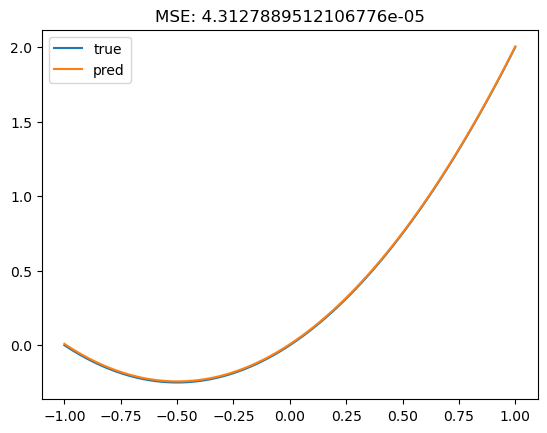

In [6]:
x_test = tf.constant(np.linspace(-1, 1, 100).reshape((-1, 1)), dtype = tf.float32)
y_test = f(x_test)
y_pred = model(x_test)

import matplotlib.pyplot as plt
plt.plot(x_test, y_test, label = "true")
plt.plot(x_test, y_pred, label = "pred")
plt.title("MSE: {}".format(np.mean((y_test - y_pred)**2)))
plt.legend()
plt.show()